# Run scMODAL on the TEA-seq PBMC dataset

In this tutorial, we apply scMODAL to the tri-modality integration of the TEA-seq data. The raw dataset is available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158013. Preprocessed data can be found here: https://drive.google.com/drive/folders/1HT7dTxd3AME-9fbXiO2cLQ_1zZnXA7AF?usp=sharing, where ATAC data were transfered to the gene activity matrix using Signac.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os

import scmodal

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

### Load data

In [2]:
adata_RNA = sc.read_h5ad('./data/tea-seq/RNA.h5ad')
adata_ATAC = sc.read_h5ad('./data/tea-seq/ATAC.h5ad')
adata_ADT = sc.read_h5ad('./data/tea-seq/ADT.h5ad')

### Identify shared and unique features

Match proteins and their coding gene names. Code and conversion file are copied and modified based on MaxFuse https://github.com/shuxiaoc/maxfuse/tree/main.

In [3]:
correspondence = pd.read_csv('./protein_gene_conversion_new.csv')
correspondence['Protein name'] = correspondence['Protein name'].replace(to_replace={'TCRab': 'TCR-a/b', 'TCRgd': 'TCR-g/d'})
print(correspondence)

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in adata_ADT.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_RNA.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

    Protein name  RNA name
0           CD80      CD80
1           CD86      CD86
2          CD274     CD274
3          CD273  PDCD1LG2
4          CD275    ICOSLG
..           ...       ...
347       Nestin       NES
348   aDefensin5     DEFA5
349          p63      TP63
350         MUC6      MUC6
351          IDO      IDO1

[352 rows x 2 columns]


In [4]:
RNA_shared = adata_RNA[:, rna_protein_correspondence[:, 0]].copy()
ADT_shared = adata_ADT[:, rna_protein_correspondence[:, 1]].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(rna_protein_correspondence[:, 0]))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(rna_protein_correspondence[:, 1]))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=1000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values

### Normalization

In [5]:
RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(np.array(RNA_counts).copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)

adata1 = ad.concat([ADT_shared, ADT_unshared], axis=1)
adata2 = ad.concat([RNA_shared, RNA_unshared], axis=1)

sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)

sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)
adata_ATAC = adata_ATAC[:, adata_ATAC.var.highly_variable].copy()
adata_ATAC.var['feature_name'] = adata_ATAC.var.index.values

adata3 = adata_ATAC.copy()
sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)
sc.pp.scale(adata3, max_value=10)

In [6]:
RNA_ATAC_shared = sorted(list(adata2.var.index & adata3.var.index))

adata23_shared = ad.concat([adata2[:, RNA_ATAC_shared], adata3[:, RNA_ATAC_shared]])
sc.tl.pca(adata23_shared, n_comps=30)

## Running scMODAL

In [7]:
model = scmodal.model.Model(training_steps=20000, model_path="./TEA-seq_PBMC")

In [8]:
model.integrate_datasets_feats(input_feats=[adata1.X, adata2.X, adata3.X], 
                              paired_input_MNN=[[adata1.X[:, :RNA_shared.shape[1]], adata2.X[:, :RNA_shared.shape[1]]], 
                                                [adata23_shared.obsm['X_pca'][:adata2.shape[0]], adata23_shared.obsm['X_pca'][adata2.shape[0]:]]])

Begining time:  Tue Oct  1 14:44:44 2024
step 0, loss_D=0.343220, loss_GAN=-0.194079, loss_AE=278.313232, loss_Geo=-11.916582, loss_LA=9018.402344, loss_MNN=70.105209
step 2000, loss_D=2.316036, loss_GAN=-2.241776, loss_AE=16.127258, loss_Geo=-29.139099, loss_LA=0.728096, loss_MNN=0.446115
step 4000, loss_D=2.310611, loss_GAN=-2.253766, loss_AE=15.033018, loss_Geo=-29.182095, loss_LA=0.527380, loss_MNN=0.368130
step 6000, loss_D=2.656654, loss_GAN=-2.594337, loss_AE=15.177022, loss_Geo=-29.202566, loss_LA=0.473842, loss_MNN=0.321554
step 8000, loss_D=2.529740, loss_GAN=-2.481193, loss_AE=14.962239, loss_Geo=-29.191803, loss_LA=0.320206, loss_MNN=0.347442
step 10000, loss_D=2.273712, loss_GAN=-2.229443, loss_AE=14.667961, loss_Geo=-29.226091, loss_LA=0.312849, loss_MNN=0.357043
step 12000, loss_D=2.512218, loss_GAN=-2.470063, loss_AE=14.772261, loss_Geo=-29.217646, loss_LA=0.261980, loss_MNN=0.348535
step 14000, loss_D=2.609316, loss_GAN=-2.528668, loss_AE=15.029343, loss_Geo=-29.220142

In [14]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_ADT.obs, adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['ADT'] * adata_ADT.shape[0] + ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_RNA.shape[0]

scmodal.utils.compute_umap(adata_integrated)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Tue Oct  1 15:38:18 2024 Construct fuzzy simplicial set
Tue Oct  1 15:38:18 2024 Finding Nearest Neighbors
Tue Oct  1 15:38:18 2024 Building RP forest with 12 trees
Tue Oct  1 15:38:18 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Oct  1 15:38:20 2024 Finished Nearest Neighbor Search
Tue Oct  1 15:38:20 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct  1 15:38:42 2024 Finished embedding


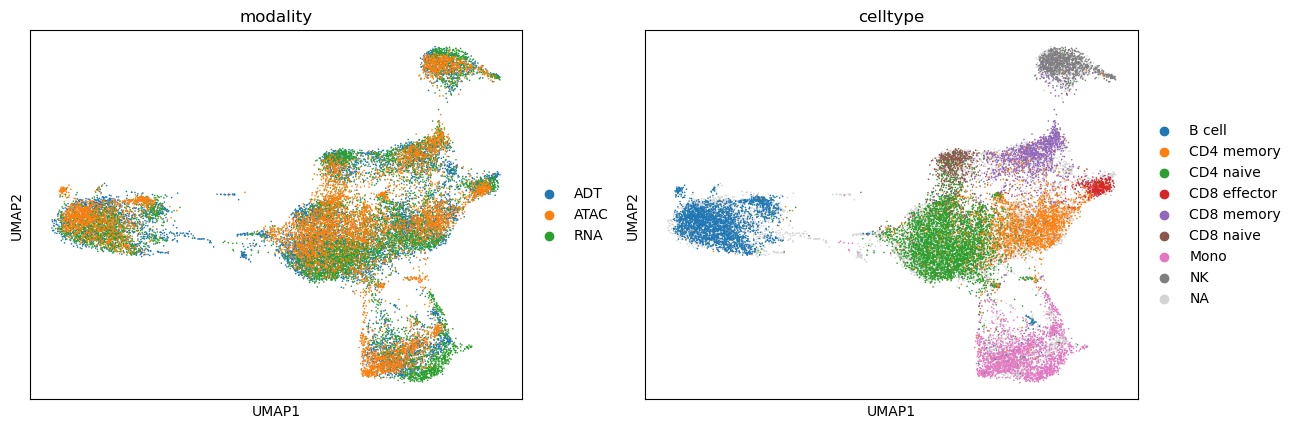

In [16]:
sc.pl.umap(adata_integrated, color=['modality', 'celltype'])